In [275]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm

from src import modelers

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prediction algorithms (supervised learning)
1. Linear Regression for predicted population count for each winner (multivariate linear regression)


1. Logistic (get beta values, or log odds ratio and look at predict proba)
2. KNN
3. Gradient Boosting Classifier (Random Forest)
Don't forget confusion matrix!!

4. We need state results (and electoral college votes) to see if they match for sum of county results.

Can we get updated demographic information to predict the 2020 elections?

5. Can we scrape twitter data and look at popularity? Maybe use NLP/NMF to look at latent features for the different tweets? Too ambitious....
6. Hate crime statistics? Starter code to download from github is in data_clean script




In [242]:
# Import data
pd.set_option("display.max_columns", 40)
data = pd.read_csv('data/cleaned_data2.csv')
data.head()

,Unnamed: 0,state,county,fips,white_pct,black_pct,hispanic_pct,foreignborn_pct,female_pct,age29andunder_pct,age65andolder_pct,median_hh_inc,clf_unemploy_pct,lesshs_pct,lesscollege_pct,rural_pct,trump16_pct,clinton16_pct,otherpres16_pct,romney12_pct,obama12_pct,otherpres12_pct,cvap_pct12,metro,rural,urban_metroadj,urban_not_metroadj
0,0,Alabama,Autauga,1001,75.683482,18.370906,2.572254,1.838362,51.176225,40.037058,13.978456,53099.0,5.591657,12.417046,75.407229,42.002162,72.766588,23.769671,3.463741,72.618252,26.587832,0.793916,58.815434,1,0,0,0
1,1,Alabama,Baldwin,1003,83.178788,9.225603,4.366698,3.269510,51.194928,35.474412,18.714851,51365.0,6.286843,9.972418,70.452889,42.279099,76.545712,19.385601,4.068687,77.358269,21.589444,1.052286,56.228504,1,0,0,0
2,2,Alabama,Barbour,1005,45.885624,47.888329,4.309762,2.859397,46.498084,37.664387,16.528895,33956.0,12.824738,26.235928,87.132213,67.789635,52.096666,46.527844,1.375490,48.223130,51.368494,0.408376,56.485890,0,0,1,0
3,3,Alabama,Bibb,1007,74.765196,21.212121,2.223994,1.351232,46.464646,37.329435,14.885699,39776.0,7.146827,19.301587,88.000000,68.352607,76.403220,21.249575,2.347205,72.826603,26.152019,1.021378,47.868107,1,0,0,0
4,4,Alabama,Blount,1009,87.657701,1.557951,8.727298,4.271801,50.485235,37.240053,17.192916,46212.0,5.953833,19.968585,86.950243,89.951502,89.334844,8.425825,2.239331,86.465884,12.371907,1.162209,56.577893,1,0,0,0


In [243]:
data.drop(columns=['Unnamed: 0', 'state', 'county', 'fips', 
                   'otherpres12_pct', 'black_pct', 'hispanic_pct'], inplace=True)

In [244]:
# Split into metro, rural, urban 
metro = data[data['metro'] == 1]
rural = data[data['rural'] == 1]
urban_metroadj = data[data['urban_metroadj'] == 1]
urban_not_metroadj = data[data['urban_not_metroadj'] == 1]

In [246]:
# Extract our labels
trump = data.pop('trump16_pct')
clinton = data.pop('clinton16_pct')
other = data.pop('otherpres16_pct')

In [247]:
# Make our X and y and do 75%/25% split
X = data
y = trump

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [248]:
# Keep track of indices
train_idx = X_train.index.values
test_idx = X_test.index.values

## Test toy model before using Kfold

In [265]:
# Standardize and fit model
X_trains, X_tests = modelers.standardize(X_train, X_test)
X_trainn, X_testn = modelers.normalize(X_train, X_test)
rmse, y_hat, model_coeff = modelers.lin_regression(X_trainn, X_testn, y_train, y_test)
rmse, model_coeff

(3.3136565999458134,
 array([ 13.87091998,  -3.71439206,   2.6399318 ,  -4.51396642,
          1.7522169 ,   6.88838613,  -4.30252461,   3.03122241,
         32.31484715,   1.73044926,  52.06826086, -15.82011228,
         -5.92553134,  -0.52806268,   0.32301352,  -0.17117564,
          0.3762248 ]))

In [266]:
# Put into dataframe
coeff = pd.DataFrame(data = model_coeff, index=data.columns, columns=["beta"])

In [267]:
# Get p-values by using stats models 
model = sm.OLS(y_train, X_trainn).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            trump16_pct   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     3041.
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        16:52:32   Log-Likelihood:                -6120.4
No. Observations:                2333   AIC:                         1.227e+04
Df Residuals:                    2316   BIC:                         1.237e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            13.8709      0.614     22.606      0.000      12.668      15.074
x2            -3.7144      1.090     -3.407      0.001      -5.852      -1.576
x3             2.6399      1.274      2.073      0.038       0.142       5.138
x4            -4.5140      1.520     -2.969      0.003      -7.495      -1.533
x5             1.7522      1.101      1.591      0.112      -0.408       3.912
x6             6.8884      1.122      6.137      0.000       4.687       9.089
x7            -4.3025      0.872     -4.936      0.000      -6.012      -2.593
x8             3.0312      1.038      2.919      0.004       0.995       5.067
x9            32.3148      1.072     30.142      0.000      30.212      34.417
x10            1.7304      0.416      4.164      0.000       0.915       2.545
x11           52.0683      4.724     11.022      0.000      42.804      61.332
x12          -15.8201      4.832     -3.274      0.001     -25.295      -6.345
x13           -5.9255      0.796     -7.443      0.000      -7.487      -4.364
x14            2.4192      5.102      0.474      0.635      -7.585      12.423
x15            3.2703      5.098      0.641      0.521      -6.727      13.268
x16            2.7761      5.104      0.544      0.587      -7.232      12.785
x17            3.3235      5.096      0.652      0.514      -6.670      13.317
==============================================================================
Omnibus:                     1269.116   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20145.405
Skew:                          -2.210   Prob(JB):                         0.00
Kurtosis:                      16.701   Cond. No.                         330.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [270]:
# Add to df
coeff['p-values'] = model.pvalues.values
coeff = coeff.apply(lambda x: round(x,2))
coeff.sort_values(by='p-values')

,beta,p-values
white_pct,13.87,0.00
cvap_pct12,-5.93,0.00
obama12_pct,-15.82,0.00
romney12_pct,52.07,0.00
rural_pct,1.73,0.00
lesshs_pct,3.03,0.00
lesscollege_pct,32.31,0.00
median_hh_inc,6.89,0.00
age29andunder_pct,-4.51,0.00
foreignborn_pct,-3.71,0.00


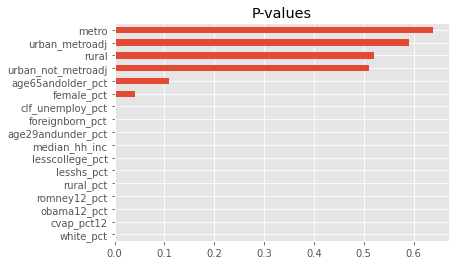

In [283]:
# Plot these to look nice
coeff.sort_values(by='p-values')['p-values'].plot(kind='barh')
plt.title("P-values")
plt.savefig('images/pvalues.png', dpi=250)

## KFold with linear regression

In [284]:
fold_scores, coeffs = modelers.kfold_scores(X_trainn, y_train, 5)
fold_scores, fold_scores.mean()

(array([3.67942969, 3.25372614, 3.06416976, 3.26909035, 3.54362916]),
 3.3620090207221645)

In [285]:
coeffs.mean(axis=0)

array([ 1.38654512e+01, -3.73438596e+00,  2.64692608e+00, -4.57186219e+00,
        1.71746522e+00,  6.88999629e+00, -4.34341205e+00,  3.03785922e+00,
        3.23141595e+01,  1.73284115e+00,  5.21459699e+01, -1.57310361e+01,
       -5.93962398e+00, -7.06683931e+12, -7.06683931e+12, -7.06683931e+12,
       -7.06683931e+12])

## Feature Engineering
The p-values of all the features show that none is significant on it's own. But I do believe certain groupings of features might be significant. 

Starting with the highest beta values, let's create these features:

- romney12_pct*lesscollege_pct
- romney12_pct*white_pct
- lesscollege_pct*white_pct
- lesscollege_pct*white_pct*romney12_pct

And let's remove these features since they are redundant with white_pct
- black_pct
- hispanic_pct

In [206]:
data_ = data.drop(columns=['black_pct', 'hispanic_pct'])
data_.head()
data_['rom*lesscol'] = data_['romney12_pct']*data_['lesscollege_pct']
data_['rom*white'] = data_['romney12_pct']*data_['white_pct']
data_['lesscol*white'] = data_['lesscollege_pct']*data_['white_pct']
data_['lesscol*white*rom'] = data_['romney12_pct']*data_['white_pct']*data_['lesscollege_pct']

In [208]:
# Now go back through train test split, standardization, and OLS to look at p-values
X_train, X_test, y_train, y_test = train_test_split(data_, trump)

In [209]:
X_trains, X_tests = modelers.standardize(X_train, X_test)

[autoreload of src.modelers failed: Traceback (most recent call last):
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/maureen/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/maureen/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/maureen/Documents/Galvanize/Capstone1/Capstone2/2016_elections/src/modelers.py", line 8, in <module>
    from sklearn.preprocessing import StandardScaler, MinMa

TypeError: cannot unpack non-iterable NoneType object

In [260]:
model = sm.OLS(y_train, X_trainn).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            trump16_pct   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     3041.
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        16:42:36   Log-Likelihood:                -6120.4
No. Observations:                2333   AIC:                         1.227e+04
Df Residuals:                    2316   BIC:                         1.237e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            13.8709      0.614     22.606      0.000      12.668      15.074
x2            -3.7144      1.090     -3.407      0.001      -5.852      -1.576
x3             2.6399      1.274      2.073      0.038       0.142       5.138
x4            -4.5140      1.520     -2.969      0.003      -7.495      -1.533
x5             1.7522      1.101      1.591      0.112      -0.408       3.912
x6             6.8884      1.122      6.137      0.000       4.687       9.089
x7            -4.3025      0.872     -4.936      0.000      -6.012      -2.593
x8             3.0312      1.038      2.919      0.004       0.995       5.067
x9            32.3148      1.072     30.142      0.000      30.212      34.417
x10            1.7304      0.416      4.164      0.000       0.915       2.545
x11           52.0683      4.724     11.022      0.000      42.804      61.332
x12          -15.8201      4.832     -3.274      0.001     -25.295      -6.345
x13           -5.9255      0.796     -7.443      0.000      -7.487      -4.364
x14            2.4192      5.102      0.474      0.635      -7.585      12.423
x15            3.2703      5.098      0.641      0.521      -6.727      13.268
x16            2.7761      5.104      0.544      0.587      -7.232      12.785
x17            3.3235      5.096      0.652      0.514      -6.670      13.317
==============================================================================
Omnibus:                     1269.116   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20145.405
Skew:                          -2.210   Prob(JB):                         0.00
Kurtosis:                      16.701   Cond. No.                         330.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""